In [83]:
import numpy as np
import matplotlib.pyplot as plt
from problemStatementGenerator import *
from ProblemMapper import *

import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import optimizers
from keras.models import Sequential



#### Building Initial Conditions

This function is for generating a random problem statment, since we do not really have a centralized dataset, this will just have to do for now as a proof of concept. That being said, what is listed here is important for us, and while these conditions will be stored offline somewhere, the process we will follow will more than likely be the same.

All the sub-function does, is unpack the conditions and the sub-arrays that are found within it, so it is no longer an object and just a straight array. We are going to use this array to generate our noise. Doing so will allow for a 'trackable' history. Each noise array will be generated by the parameters themselves. At the moment, it is possible to have collisions, but this method can be expanded upon to create a better 'key' system. For our purposes, it will do just fine.

In [84]:
YoungsModulusMax = 1e+12
YoungsModulusMin = 1e+9

CmaxRatio = 1e-5
CminRatio = 1e-3
ComplianceMinVal = 0

SmaxRatio = 1e+8
SminRatio = 1e+6
StressMinVal = 0

nelx, nely, nelz = 50, 100, 25

In [85]:
def generateProblem(nelx=50, nely=100):

    xDim, yDim = calcRatio(nelx, nely) # Length, Width

    c1, c2, c3, forces = FenicsCircleAndForceGenerator(xDim, yDim)
    Y, C_max, S_max = createConstraints(YoungsModulusMin,YoungsModulusMax,CmaxRatio,CminRatio,ComplianceMinVal,SmaxRatio,SminRatio,StressMinVal)


    initial_conditions = [c1, c2, c3, forces, nelx, nely, Y, C_max, S_max]

    def unpackConditions(conditions):
        unpackedConditions = []

        circles = initial_conditions[:3]

        for x in range(3):
            for variable in circles[x]:
                unpackedConditions.append(variable)

            unpackedConditions.append(forces[0, x])
            unpackedConditions.append(forces[1, x])

        for x in range(4, len(conditions)):
            unpackedConditions.append(conditions[x])

        return unpackedConditions
    
    unpackedConditions = np.array(unpackConditions(initial_conditions))
    

    return unpackedConditions, initial_conditions

In [86]:
np.random.seed(42)  # So the problem that is generated will always be the same. Comment this out for an actual random problem.

unpacked, packed = generateProblem(nelx, nely)

print("\nGenerated Problem:")
print(unpacked)
print(len(unpacked))
print(unpacked.shape)

c1, c2, c3 = packed[0], packed[1], packed[2]
forces = packed[3]
nelx, nely = packed[4], packed[5]
Y, C_max, S_max = packed[6], packed[7], packed[8]


Generated Problem:
[ 3.74540119e-01  1.63400303e+00  5.97721439e-02  3.33322307e+03
  4.97285658e+03  4.33088073e-01  4.33088073e-01  7.07290078e-02
 -1.56532137e+03 -5.80380688e+03  2.77480880e-01  1.72251912e+00
  4.53162961e-02 -1.76790170e+03  8.30950299e+02  5.00000000e+01
  1.00000000e+02  2.13126772e+11  8.19993282e-04  1.91570465e+07]
20
(20,)


#### Creating Noise Array Based on Inital Conditions
The noise array is built off the initial conditions in 2 ways at first:
- Setting np.random.seed(x) where x:
    - x = abs(sum(cond))
- Size = (nelx, nely, len(unpacked))
    - unpacked is our conditions array, so the number of elements dictates our starting depth. Each layer within the noise array however, is a random value of (1-255), dictated by our .seed(x) value. So it's partially determined, partially random.

213145928769.12473
21314592876.91247
2131459287.6912472
(50, 100, 20)


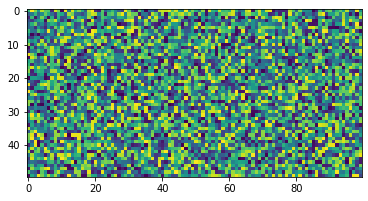

In [87]:
newSeed = np.sum(unpacked)
print(newSeed)

while newSeed > (2**32 - 1):
    newSeed /= 10
    print(newSeed)
    
newSeed = np.abs(int(newSeed)) 

np.random.seed(newSeed)

noise = np.random.randint(1, 256, size=(nelx, nely, len(unpacked)))
print(noise.shape)
plt.imshow(noise[:, :, 0])

## Kept for Posterities Sake'

Because it is not working at the moment, and I don't think it will. On top of that, it is more used for encodding, I suppose, and thus is not entirely useful for us to begin with. Oh well, 30 minutes learning something new is worthwhile in the long run.

#### A Quick Detour: The Embedding Layer

So Keras has a layer called the 'Embedding' layer. The documentation online says that it only takes in positive values, and I know that our conditions sometimes take on negative values, so the aim of this is to see if it will take any kind of input that we throw at it. Otherwise, the embedding layer will just not be used.

In [88]:
model = Sequential()
embedding = layers.Embedding(input_dim=1000, output_dim=64)
# embedding = layers.Embedding(input_dim=1000, output_dim=64, input_length=20)
model.add(embedding)
model.compile('adam', 'mse')


input_array = np.random.randint(1000, size=(32,20))

pred = model.predict(input_array)
print(input_array.shape)
# print(pred)


1/1 [==============================] - 0s 95ms/step
(32, 20)


## Model Building

### Generator
The generator is a split model, such that it takes in the problem discription and the noise array and then merges to pass through several convolutional layers.
Having the split for different inputs gives us the ability to actually guide our generator, which is _exactly_ what we want.

This first generator is simply a framework to build variations off of. Simple, and flexible.

In [89]:
# Very simple Generator model framework (make changes off of this(?))
def generator():
    # Label inputs of model, this will hold (roughly) true for every architecture
    label_input = layers.Input(shape=unpacked.shape)
    
    # CNN param to resize to
    shape_0, shape_1 = 64, 64
    n_nodes = shape_0 * shape_1

    # Label input
    labels = layers.Dense(n_nodes)(label_input)
    labels = layers.Reshape((shape_0, shape_1, 1))(labels)


    # Update to n_nodes to match Gen branch
    n_nodes = shape_0 * shape_1 * 128

    # Generator noise array input model
    noise_input = layers.Input(100)
    gen = layers.Dense(n_nodes)(noise_input)
    gen = layers.ReLU()(gen)
    gen = layers.Reshape((shape_0, shape_1, 128))(gen)

    merge = layers.Concatenate()([gen, labels])
    resize = layers.Resizing(height=128, width=64)(merge)


    # Layer 1
    gen = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2),
                                padding='same')(resize)
    gen = layers.ReLU()(gen)

    # Layer 2
    gen = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(1,1),
                                padding='same')(gen)
    gen = layers.ReLU()(gen)
    gen = layers.MaxPool2D(pool_size=(2,2))(gen)

    # Output & Model object
    output = layers.Conv2D(filters=1, kernel_size=(7,7), activation='tanh',
                           padding='same')(gen)
    output = layers.Resizing(height=100, width=50)(output)

    model = keras.models.Model([noise_input, label_input], output)
    
    return model

In [90]:
gen1 = generator()
gen1.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_27 (Dense)               (None, 524288)       52953088    ['input_28[0][0]']               
                                                                                                  
 input_27 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 re_lu_31 (ReLU)                (None, 524288)       0           ['dense_27[0][0]']               
                                                                                           

In [91]:
print(gen1.output)
print("\n", gen1.input)

# gen_predict = gen1.predict(noise, unpacked)
# print(gen_predict)
# print(gen_predict.shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 50, 1), dtype=tf.float32, name=None), name='resizing_17/resize/ResizeBilinear:0', description="created by layer 'resizing_17'")

 [<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'input_28')>, <KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'input_27')>]


### Discriminator

Our Discriminator is also a split model. Most of the architecture will follow sorta an inverse of the discriminator, at least in terms of resolutions. While our generator creates images that end as 100x50xD (where D is the depth), our discriminator takes in images at that resolution and results in a simple classification node.

In [92]:
def discriminator():

    label_input = layers.Input(shape=unpacked.shape)

    # CNN param to resize to
    shape_0, shape_1 = 100, 50
    n_nodes = shape_0 * shape_1

    # Label input
    labels = layers.Dense(n_nodes)(label_input)
    labels = layers.Reshape((shape_0, shape_1, 1))(labels)


    # This is our input from the image
    image_input = layers.Input(shape=(100, 50, 1))
    # image = layers.Reshape((shape_0, shape_1, 1))(image_input)
    # image = layers.Dense(n_nodes)(image_input)
    # # image = layers.Reshape((shape_0, shape_1, 1))(image)
    # image = layers.Reshape((shape_0, shape_1, 1))(image_input)


    merge = layers.Concatenate()([labels, image_input])

    dis = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same')(merge)
    dis = layers.LeakyReLU(alpha=0.2)(dis)

    dis = layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same')(dis)
    dis = layers.LeakyReLU(alpha=0.2)(dis)
    dis = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(dis)

    dis = layers.Flatten()(dis)
    dis = layers.Dropout(0.2)(dis)

    output = layers.Dense(1)(dis)

    model = keras.models.Model([image_input, label_input], output)

    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                  metrics=['accuracy'])
    
    return model




In [93]:
dis1 = discriminator()
dis1.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 dense_28 (Dense)               (None, 5000)         105000      ['input_29[0][0]']               
                                                                                                  
 reshape_26 (Reshape)           (None, 100, 50, 1)   0           ['dense_28[0][0]']               
                                                                                                  
 input_30 (InputLayer)          [(None, 100, 50, 1)  0           []                               
                                ]                                                          

### Merging of Generator and Discriminator into a full "cDCGAN"

Here we are putting both sub-models together into one full model, essentially.
Luckily, this function is a very plug-in, shit-out, function. So our generator and discriminator are defined outside and then put together. 

**_Meaning:...._** 
##### OUR GANs CAN BE COMPOSED OF MANY DIFFERENT GENERATORS AND DISCRIMINIATORS
So in reality, we need to be creating and trying different combinations of models. Perhaps one combination performs far better than another. It will also be worth figurein

In [94]:
def full_gan(gen, dis):
    dis.trainable = False

    gen_noise, gen_label = gen.input
    gen_output = gen.output

    gan_output = dis([gen_output, gen_label])

    model = keras.models.Model([gen_noise, gen_label], gan_output)

    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    
    return model

In [95]:
gan_model_1 = full_gan(gen1, dis1)
gan_model_1.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_27 (Dense)               (None, 524288)       52953088    ['input_28[0][0]']               
                                                                                                  
 input_27 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 re_lu_31 (ReLU)                (None, 524288)       0           ['dense_27[0][0]']               
                                                                                           